# **Introduction**

Resnets introduced in [this](https://arxiv.org/pdf/1512.03385.pdf) paper, are solving a degradation problem which concerns very deep standard neural network architectures.
Degradation is counterintuitive behaviour of deep neural networks, it takes place when
trained very deep model has a training error and test error rate significantly higher than shallower architectures.
Research team hypothesized that it can be due to fact, that deep networks have a problem with learn an identity mapping between layers which they prove empirically.

In this notebook i will implement an resnet variation for classifying a CIFAR-10 dataset.



## **1. Data preprocessing and initial configuration**

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
import numpy as np
from resnet import ResNet
from utils import *



> Augmenting data and dividing dataset as described in paper.



In [ ]:
transform = transforms.Compose([transforms.Pad(4),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(32),
                                transforms.ToTensor()])

train_loader, valid_loader, test_loader = load_data(transform=transform, valid_size=0.9)

## **2. Model**



> Network is implemented in 'resnet.py' file. </br>
> To make sure, that model is implemented correctly, i will overfit 
> it to one batch of data.



In [ ]:
model = ResNet(size=5)
x, y = next(iter(train_loader))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

for epoch in range(100):
  scores = model(x)
  loss = criterion(scores, y)

  if (epoch+1) % 10 == 0:
    print("Loss in epoch {}: {}".format((epoch+1), loss.item()))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Loss in epoch 10: 2.2568840980529785
Loss in epoch 20: 1.049072027206421
Loss in epoch 30: 0.2272595763206482
Loss in epoch 40: 0.029123462736606598
Loss in epoch 50: 0.007931246422231197
Loss in epoch 60: 0.0036732323933392763
Loss in epoch 70: 0.0024713214952498674
Loss in epoch 80: 0.001950036734342575
Loss in epoch 90: 0.0016692706849426031
Loss in epoch 100: 0.0014904745621606708


> As shown above, loss is decreasing over time so model is 
> capable to learn.

## **3. Training**



> Training phase is pretty well described in paper with all hyperparameters given, </br>
> so I'll use them instead doing hyperparameters tuning. </br>
> I will train two very deep models - 44 layers - to compare their performance.
> One model will be resnet and second will be a plain convolutional neural network.



In [7]:
resnet44 = ResNet(7)
plain44 = ResNet(7, shortcuts=False)

models = {'resnet44': resnet44, 'plain44': plain44}
results = {}

epochs = 80

In [ ]:
for name, model in models.items():

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-4)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, threshold=1e-2)

  results[name] = {'tr_loss': [], 'val_loss': []}

  cur_lr = 0.1
  best_val_loss = np.inf

  print('-'*20)
  print("TRAINING: ", name.upper())
  print('-'*20)

  for epoch in range(epochs):
    train_loss = train(model, optimizer, criterion, train_loader)

    print("\nTraining loss in epoch {}: {}".format((epoch+1), train_loss))

    scheduler.step(train_loss)

    for param in optimizer.param_groups:
      lr = param['lr']
    
    if lr < cur_lr:
      print("Learning rate was reduced from {} to {}.".format(cur_lr, lr))
      cur_lr = lr

    if (epoch+1) % 5 == 0:
      validation_loss = validate(model, criterion, valid_loader)

      print("Validation loss in epoch {}: {}".format((epoch+1), validation_loss))

      if validation_loss < best_val_loss:
        best_val_loss = validation_loss

        print("Achieved new best validation loss, saving model parameters.")
        torch.save(model.state_dict(), "./{}_state.pt".format(name))
      
      
      results[name]['tr_loss'].append(train_loss)
      results[name]['val_loss'].append(validation_loss)   



> Loading best set of parameters for each model.



In [9]:
for name, model in models.items():
  model.load_state_dict(torch.load("./{}_state.pt".format(name)))

## **4. Results**

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.figure(figsize=(50, 30))

fig, axs = plt.subplots(2, 2, dpi=100)
fig.tight_layout()

In [20]:
results_res44 = results['resnet44']
results_plain44 = results['plain44']

x_values = 5 * np.arange(1, len(results_res44['tr_loss']) + 1, 1)

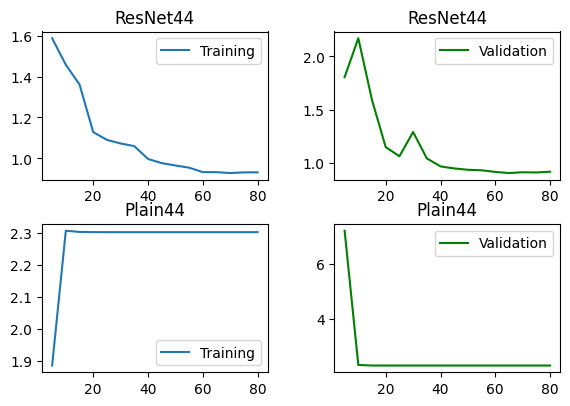

In [31]:
axs[0][0].title.set_text('ResNet44')
axs[0][1].title.set_text('ResNet44')
axs[0][0].plot(x_values, results_res44['tr_loss'], label='Training')
axs[0][1].plot(x_values, results_res44['val_loss'], 'g', label='Validation')
axs[0][0].legend(loc="upper right")
axs[0][1].legend(loc="upper right")


axs[1][0].title.set_text('Plain44')
axs[1][1].title.set_text('Plain44')
axs[1][0].plot(x_values, results_plain44['tr_loss'], label='Training')
axs[1][1].plot(x_values, results_plain44['val_loss'], 'g', label='Validation')
axs[1][0].legend(loc="lower right")
axs[1][1].legend(loc="upper right")

fig



> As we can see on plot, resnet validation loss and training loss </br>
> decreased over time, when training and validation loss of plain cnn practically did not change, training loss even increased. </br>
> We can clearly see, that degradation problem is well addressed by resnet.

In [29]:
print("ResNet44 accuracy: {:.2%}".format(evaluate_acc(resnet44, test_loader)))
print("Plain44 accuracy: {:.2%}".format(evaluate_acc(plain44, test_loader)))

ResNet44 accuracy: 65.41%
Plain44 accuracy: 10.00%




> 10% accuracy score for plain network clearly shows, that this model
> did not learn anything. </br>CIFAR-10 contains 10 classes, so accuracy of this model is equal to accuracy of random guessing correct class of given image.





> 

